In [29]:
import xarray as xr
import numpy as np
import geopandas as gpd
import cartopy.io.shapereader as shpreader
from shapely.geometry import box
import shapely.vectorized as sv

In [30]:
def average_capacity_factors(filename):
    '''
    Function to read in a .nc file and calculate the average capacity factors over time.
    '''
    ds = xr.open_dataset(filename)

    cf_avg = ds.mean(dim='time')

    return cf_avg

def get_top_25_percent_cfs(avg_capacity_factors):
    '''
    Function to get the top 25% of capacity factors.
    '''
    cfs_25 = avg_capacity_factors.where(avg_capacity_factors > avg_capacity_factors.quantile(0.75), 0)

    return cfs_25

In [31]:
def get_time_series_top_25_percent_cfs(filename, cfs_25, cf_type):
    '''
    Function to get the time series of the top 25% of capacity factors.
    '''
    ds = xr.open_dataset(filename)

    # Save average over all grid cells to csv file
    ds_avg = ds.mean(dim=['x', 'y'])
    ds_avg_df = ds_avg.to_dataframe()
    ds_avg_df = ds_avg_df.rename(columns={'capacity factor': f'{cf_type}_cf_avg'})
    year = filename.split('_')[-1].split('.')[0]
    ds_avg_df.to_csv(f'CONUS_{cf_type}_CF_avg_all_{year}.csv')

    # Get time series of top 25% grid cells
    cfs_25_ts = ds.where(cfs_25 > 0)

    # Average over all grid cells
    cfs_25_ts = cfs_25_ts.mean(dim=['x', 'y'])

    # Write to csv file
    cfs_25_df = cfs_25_ts.to_dataframe()

    # Drop columns execpt for time and capacity factor
    cfs_25_df = cfs_25_df.drop(columns=['quantile'])
    # Rename columns
    cfs_25_df = cfs_25_df.rename(columns={'capacity factor': f'{cf_type}_cf'})
    
    # Write to csv file
    year = filename.split('_')[-1].split('.')[0]
    cfs_25_df.to_csv(f'CONUS_{cf_type}_CF_{year}.csv')

In [32]:
def plot_capacity_factor(cf):
    """
    Plot map pf capacity factor
    """

    shpfilename = shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_0_countries"
    )
    reader = shpreader.Reader(shpfilename)
    # Mask US 
    US = gpd.GeoSeries(
        {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
        crs={"init": "epsg:4326"}).reindex(["United States of America"])

    # Only keep contiguous US
    contiguous_48_bbox = box(minx=-125, miny=24.396308, maxx=-66.93457, maxy=49.384358)
    # Clip the US geometry to the bounding box
    conus = US.geometry.intersection(contiguous_48_bbox)
    # Mask the capacity factor data to the US geometry
    # Extract the geometry from the GeoSeries (use unary_union if there are multiple polygons)
    conus_geom = conus.unary_union if len(conus) > 1 else conus.iloc[0]

    # Get the grid of coordinates (lon, lat) from the xarray DataArray
    lon, lat = np.meshgrid(cf['x'], cf['y'])

    # Use shapely's vectorized.contains to create a mask for points within the conus
    mask = sv.contains(conus_geom, lon, lat)

    # Apply the mask to the cf DataArray
    masked_dataset = cf.where(mask)

    # Set aspect ratio
    aspect_ratio = (cf['x'].max()-cf['x'].min())/(cf['y'].max()-cf['y'].min())
    # Set color scale limits
    masked_dataset["capacity factor"].plot(aspect=aspect_ratio, size=5, vmin=0.)

    # Print mean capacity factor without zeros
    print(masked_dataset["capacity factor"].where(masked_dataset["capacity factor"] > 0).mean().values)


In [33]:
# Solar capacity factor
# cf_solar = average_capacity_factors('conus_solar_CF_timeseries_2023.nc')
# cf_solar_25 = get_top_25_percent_cfs(cf_solar)
# plot_capacity_factor(cf_solar)
# plot_capacity_factor(cf_solar_25)
# get_time_series_top_25_percent_cfs('conus_solar_CF_timeseries_2023.nc', cf_solar_25, 'solar')

/home/awongel/miniconda3/envs/atlite/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


0.18977940131315973


/home/awongel/miniconda3/envs/atlite/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


0.3853121289316194


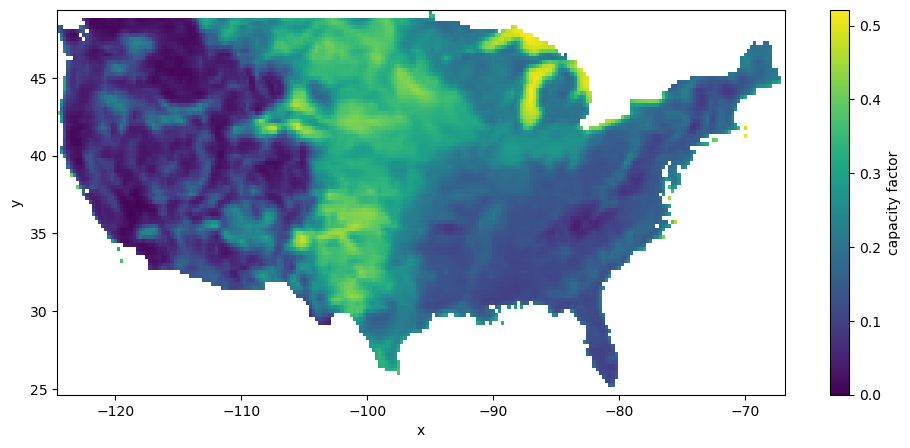

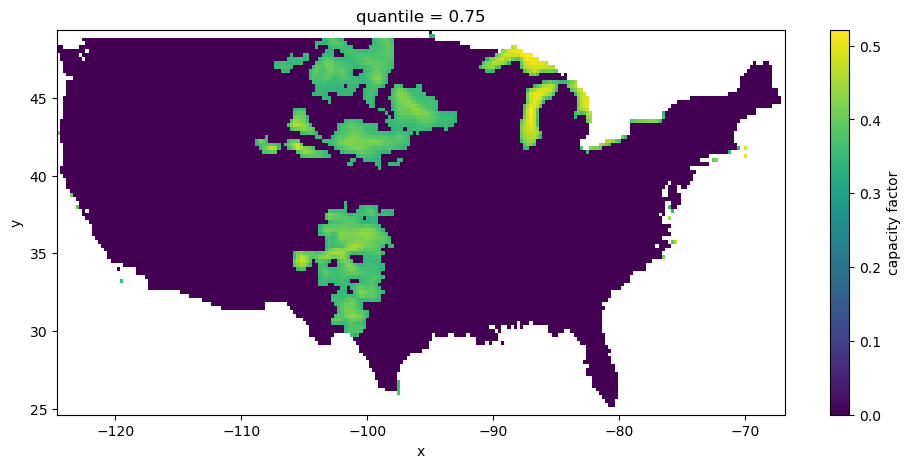

In [34]:
# Wind capacity factor

cf_wind = average_capacity_factors('conus_wind_CF_timeseries_2023.nc')
cf_wind_25 = get_top_25_percent_cfs(cf_wind)
plot_capacity_factor(cf_wind)
plot_capacity_factor(cf_wind_25)
get_time_series_top_25_percent_cfs('conus_wind_CF_timeseries_2023.nc', cf_wind_25, 'wind')